In [1]:
import os
import glob

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [3]:
from PIL import Image

In [4]:
import torch
import torchvision as tv
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader

In [5]:
# CUDA stuff
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


In [6]:
use_cuda

True

(420, 540)


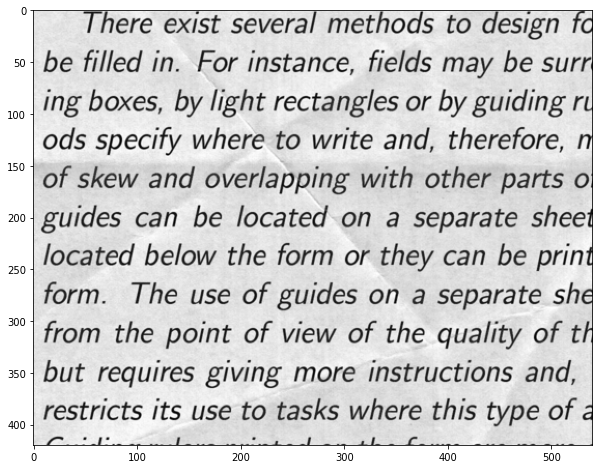

In [48]:
plt.figure(figsize=(20,8))

# flag of 0 means load in greyscale mode
img = cv2.imread('./data/train/101.png', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

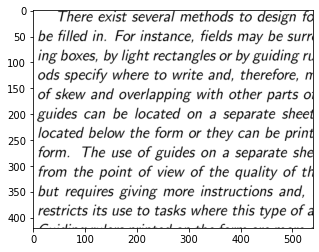

In [49]:
img = cv2.imread('./data/train_cleaned/101.png', 0)
plt.imshow(img, cmap='gray')

In [44]:
img.shape

(420, 540)

TypeError: Image data of dtype object cannot be converted to float

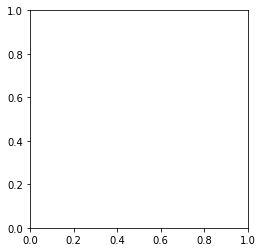

In [45]:
img = cv2.imread('./data/test/101.png', 0)
plt.imshow(img, cmap='gray')

In [8]:
TRAIN_IMAGES = glob.glob('./data/train/*.png')
CLEAN_IMAGES = glob.glob('./data/train_cleaned/*.png')
TEST_IMAGES = glob.glob('./data/test/*.png')

In [115]:
TRAIN_IMAGES

['./train\\101.png',
 './train\\102.png',
 './train\\104.png',
 './train\\105.png',
 './train\\107.png',
 './train\\108.png',
 './train\\11.png',
 './train\\110.png',
 './train\\111.png',
 './train\\113.png',
 './train\\114.png',
 './train\\116.png',
 './train\\117.png',
 './train\\119.png',
 './train\\12.png',
 './train\\120.png',
 './train\\122.png',
 './train\\123.png',
 './train\\125.png',
 './train\\126.png',
 './train\\128.png',
 './train\\129.png',
 './train\\131.png',
 './train\\132.png',
 './train\\134.png',
 './train\\135.png',
 './train\\137.png',
 './train\\138.png',
 './train\\14.png',
 './train\\140.png',
 './train\\141.png',
 './train\\143.png',
 './train\\144.png',
 './train\\146.png',
 './train\\147.png',
 './train\\149.png',
 './train\\15.png',
 './train\\150.png',
 './train\\152.png',
 './train\\153.png',
 './train\\155.png',
 './train\\156.png',
 './train\\158.png',
 './train\\159.png',
 './train\\161.png',
 './train\\162.png',
 './train\\164.png',
 './train\\165.pn

In [116]:
a = TRAIN_IMAGES[0]
a

'./train\\101.png'

In [117]:
os.path.basename(a)

'101.png'

In [100]:
os.path.join('./data/train/', '*.png')

'./data/train/*.png'

In [10]:
def load_images(path_arr):
    image_list = np.zeros((len(path_arr), 258, 540, 1))
    for i, fig in enumerate(path_arr):
        img = tv.load_images

In [16]:
lol = 
np.zeros((len(TRAIN_IMAGES), 258, 540, 1))

SyntaxError: invalid syntax (<ipython-input-16-3c25904bc65d>, line 1)

In [7]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        dirty_img, clean_img = sample['dirty_img'], sample['clean_img']

        h, w = dirty_img.shape[:2]
        new_h, new_w = self.output_size
#         print('prev img')
#         print(h, w)
#         print('new img')
#         print(new_h, new_w)
#         print(w - new_w)
        
        if h - new_h > 0:
            top = np.random.randint(0, h - new_h)
        else:
            top = 0
        
        if w - new_w > 0:
            left = np.random.randint(0, w - new_w)
        else:
            left = 0

        dirty_img = dirty_img[top: top + new_h,
                      left: left + new_w]
        clean_img = clean_img[top: top + new_h,
                      left: left + new_w]

        return {'dirty_img': dirty_img, 'clean_img': clean_img}

In [50]:
class ToTensor(object):
    """convert ndarrays in sample to Tensors"""
    
    def __call__(self, sample):
        dirty_img, clean_img = np.float32(sample['dirty_img']), np.float32(sample['clean_img'])
        
        return {'dirty_img': torch.from_numpy(dirty_img).unsqueeze(0), 'clean_img': torch.from_numpy(clean_img).unsqueeze(0)}
        
        

In [51]:
class DocumentsDataset(Dataset):
    """documents dataset"""
    
    def __init__(self, dirty_dir, clean_dir, transform=None):
        super(DocumentsDataset, self).__init__()
        self.dirty_arr = glob.glob(os.path.join(dirty_dir, '*.png'))
        self.clean_arr = glob.glob(os.path.join(clean_dir, '*.png'))
        self.dirty_dir = dirty_dir
        self.clean_dir = clean_dir
        self.transform = transform
    
    def __len__(self):
        # could be dirty arr or clean arr, shouldn't matter
        return len(self.dirty_arr)
    
    def __getitem__(self, index):
        """Generate one sample of data, based on dirty data"""
        img_name = os.path.basename(self.dirty_arr[index])
        dirty_path = os.path.join(self.dirty_dir, img_name)
        clean_path = os.path.join(self.clean_dir, img_name)
        dirty_img = cv2.imread(dirty_path, 0)
        clean_img = cv2.imread(clean_path, 0)
        
#         dirty_img = Image.open(dirty_path)
#         clean_img = Image.open(clean_path)
    
    
#         print(type(dirty_img))
#         print(dirty_path)
#         print(self.dirty_dir)
#         print('before transform')
#         print(dirty_img.shape)
#         print(clean_img.shape)
        
#         i, j, h, w = transforms.RandomCrop.get_params(
#             dirty_img, output_size=(258, 540))
#         dirty_img = TF.crop(dirty_img, i, j, h, w)
#         clean_img = TF.crop(clean_img, i, j, h, w)
        
        if self.transform:
            transformed = self.transform({'dirty_img': dirty_img, 'clean_img': clean_img})
            dirty_img, clean_img = transformed['dirty_img'], transformed['clean_img']
        clean_img = clean_img / 255.0
        return dirty_img, clean_img

In [202]:
type(cv2.imread('./data/train/101.png', 0))

numpy.ndarray

In [159]:
cv2.imread('./data/train/101.png', 0).shape

(420, 540)

In [209]:
testimg = cv2.imread('./data/train/101.png', 0)
testimg

array([[233, 234, 236, ..., 231, 231, 233],
       [232, 229, 229, ..., 236, 235, 233],
       [221, 222, 225, ..., 233, 235, 236],
       ...,
       [218, 213, 215, ..., 221, 222, 228],
       [223, 223, 226, ..., 226, 215, 209],
       [235, 229, 226, ..., 156,  96,  61]], dtype=uint8)

In [213]:
torch.from_numpy(testimg).unsqueeze(0).shape

torch.Size([1, 420, 540])

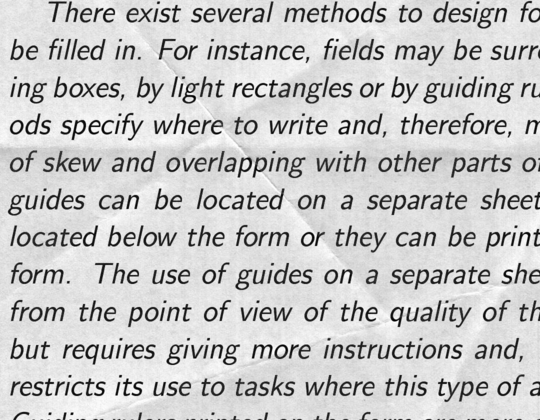

In [158]:
a = Image.open('./data/train/101.png')
a

In [24]:
dirty_dir = './data/train/'

lmao = os.path.join(dirty_dir, '101.png')
lmao

'./data/train/101.png'

In [27]:
tv.load_image

<module 'torchvision' from 'C:\\Users\\adaml\\Anaconda3\\envs\\pytorch-sandbox\\lib\\site-packages\\torchvision\\__init__.py'>

In [77]:
document_dataset = DocumentsDataset(dirty_dir='./data/train/', clean_dir='./data/train_cleaned/')
document_dataset

TypeError: 'DocumentsDataset' object is not an iterator

In [52]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), padding=(1, 1))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), padding=(1, 1))
        self.conv4 = nn.Conv2d(64, 64, (3, 3), padding=(1, 1))
        self.conv5 = nn.Conv2d(64, 64, (3, 3), padding=(1, 1))
        self.conv6 = nn.Conv2d(64, 1, (3, 3), padding=(1, 1))
        
        self.l_relu1 = nn.LeakyReLU()
        self.l_relu2 = nn.LeakyReLU()
        self.l_relu4 = nn.LeakyReLU()
        self.l_relu5 = nn.LeakyReLU()
        
        self.b_norm1 = nn.BatchNorm2d(64)
        self.b_norm4 = nn.BatchNorm2d(64)
        
        self.max_pool3 = nn.MaxPool2d((2, 2))
        
#         # can try replacing with nn.ConvTranspose2d if want weights
        self.upsample5 = nn.Upsample(scale_factor=(2, 2), mode='nearest')
        
        self.sigmoid6 = nn.Sigmoid()
        
        
    def forward(self, x):
#         print('preforward pass')
#         print(x.shape)
        x = self.conv1(x)
#         print('post conv1')
#         print(x.shape)
        x = self.l_relu1(x)
#         x = F.leaky_relu(x)
        x = self.b_norm1(x)
        
        x = self.conv2(x)
        x = self.l_relu2(x)
#         x = F.leaky_relu(x)
        
        x = self.max_pool3(x)
#         x = F.max_pool2d(x, 2, 2)
        
        x = self.conv4(x)
#         x = F.leaky_relu(x)
        x = self.l_relu4(x)
        x = self.b_norm4(x)
        
        x = self.conv5(x)
#         x = F.leaky_relu(x)
        x = self.l_relu5(x)
        x = self.upsample5(x)
#         x = F.upsample(x, scale_factor = (2, 2))
        
        x = self.conv6(x)
        x = self.sigmoid6(x)
        return x

In [53]:
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 10}
# params = {'batch_size': 4,
#           'shuffle': True,
#           'num_workers': 0}
max_epochs = 200
trans = transforms.Compose([RandomCrop((258, 540)), ToTensor()])

training_set = DocumentsDataset(dirty_dir='./data/train/', clean_dir='./data/train_cleaned/', transform=trans)
training_generator = DataLoader(training_set, **params)

# todo: add validation set split and generator

test_set = DocumentsDataset(dirty_dir='./data/test/', clean_dir='./data/train_cleaned/')
test_generator = DataLoader(training_set, **params)




In [17]:
dataiter = iter(training_generator)
dirty, clean = dataiter.next()

In [282]:
dirty, clean = dataiter.next()
dirty.shape, clean.shape

StopIteration: 

In [231]:
dirty.shape

torch.Size([4, 1, 258, 540])

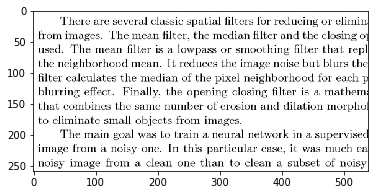

In [222]:
plt.imshow(dirty[2][0], cmap='gray')

In [232]:
dirty[2][0]

tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]])

In [ ]:
cv.imread('./data/train/101.png', 0)

In [205]:
poo = 0
for i, data in enumerate(training_generator):
        # grab inputs
        local_dirty, local_clean = data
        
        if i == 5:
            break
local_dirty

tensor([[[255, 255, 255,  ..., 246, 255, 255],
         [255, 255, 255,  ..., 255, 253, 253],
         [255, 255, 255,  ..., 254, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 134,  24,  19],
         [255, 255, 255,  ..., 255, 246, 243],
         [255, 255, 255,  ..., 253, 255, 255],
         ...,
         [255, 255, 255,  ...,  26, 116, 227],
         [255, 255, 255,  ...,  14,   0,  39],
         [255, 255, 255,  ..., 227,  63,   0]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 254, 255],
         [255, 255, 255,  ..., 254, 253, 255],
         [25

In [15]:
del model

In [57]:
model = AutoEncoder()
model = model.to(device)

In [58]:

# we gotta square root this later on to make RMSE loss fn
criterion = nn.MSELoss()
# loss = torch.sqrt(criterion)
optimizer = optim.Adam(model.parameters()) # can add lr and momentum params


In [59]:
for epoch in range(max_epochs):
    
    running_loss = 0.0
    # training
    for i, data in enumerate(training_generator):
        # grab inputs
        local_dirty, local_clean = data
#         print(local_dirty.shape)
        
        # transfer to GPU
        local_dirty, local_clean = local_dirty.to(device), local_clean.to(device)
        
        # model computation
        
        # zero param gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(local_dirty)
#         print('outputs')
#         print(outputs.shape)
        
        # loss
        loss = torch.sqrt(criterion(outputs, local_clean))
        loss.backward()
        
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        if i % 10 == 9: # i % print_every_n == print_every_n - 1
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10)) # replace denom with print_every_n
            running_loss = 0.0
    
#     # validation
#     with torch.set_grad_enabled(False):
#         for local_dirty, local_clean in validation_generator:
#         # transfer to GPU
#         local_dirty, local_clean = local_dirty.to(device), local_clean.to(device)
        
#         # model computation
#         ... 
        

In [60]:
dataiter = iter(training_generator)
dirty1, clean1 = dataiter.next()

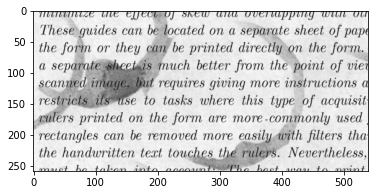

In [61]:
plt.imshow(dirty1[0][0], cmap='gray')

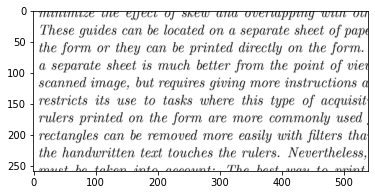

In [62]:
plt.imshow(clean1[0][0], cmap='gray')

In [35]:
dataiter = iter(training_generator)
dirty, clean = dataiter.next()

In [63]:
with torch.set_grad_enabled(False):
    dirty, clean = dirty1.to(device), clean1.to(device)
    outputs = model(dirty).to(device)
    print('hurray')
    

hurray


In [64]:
outputs.shape

torch.Size([16, 1, 258, 540])

In [65]:
outputs = outputs.cpu()

In [66]:
outputs * 255

tensor([[[[250.5207, 254.5645, 254.0315,  ...,  14.4310,  42.9458, 196.1781],
          [253.8972, 254.9541, 254.9505,  ...,   1.5981, 133.0452, 248.5372],
          [253.8691, 254.9507, 254.9543,  ...,   8.9887, 236.3309, 249.1607],
          ...,
          [254.2245, 254.9805, 254.9667,  ..., 254.8330, 254.5701, 251.9740],
          [254.0947, 254.9812, 254.9771,  ..., 254.9001, 254.8110, 253.2980],
          [249.7997, 254.6584, 254.6850,  ..., 253.7809, 254.2852, 251.3840]]],


        [[[249.5062, 253.9544, 250.6118,  ..., 253.6836, 251.7667, 246.4325],
          [253.4682, 254.8131, 254.3382,  ..., 253.8086, 253.7619, 252.2552],
          [253.6838, 254.9180, 254.7855,  ..., 251.9540, 252.3466, 251.3968],
          ...,
          [254.1957, 254.9799, 254.9663,  ..., 245.0047, 249.2139, 239.3615],
          [254.0648, 254.9788, 254.9682,  ...,  10.0189,  20.8561,  72.7425],
          [250.6451, 254.7188, 254.6683,  ..., 103.9809,  69.5047,  78.2077]]],


        [[[250.0765, 254.5

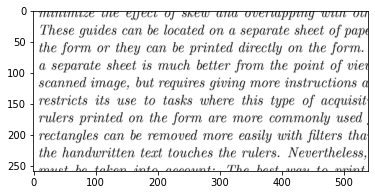

In [67]:
plt.imshow(clean[0][0].cpu(), cmap='gray')

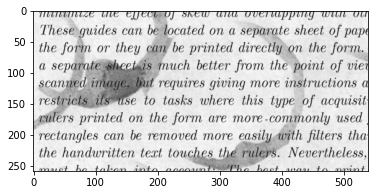

In [68]:
plt.imshow(dirty[0][0].cpu(), cmap='gray')

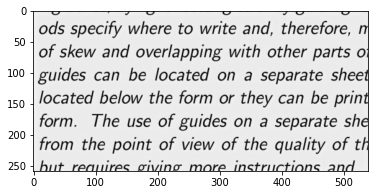

In [40]:
plt.imshow(outputs[0][0] * 255.0, cmap='gray')